In [1]:
import numpy as np
import pyedflib
import connectivipy as cp
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats as st
import seaborn as sns
import scipy.signal as sig

In [2]:
# reading data from sources

f1 = "../data/S003R01.edf"
f2 = "../data/S003R02.edf"

edf1 = pyedflib.EdfReader(f1)
edf2 = pyedflib.EdfReader(f2)

sampling_frequency = 160.0

locations = {x[1][1]:(x[1]['x'], x[1]['y']) for x in pd.read_csv("locations.txt", sep = "\s+").iterrows()}

In [3]:
def get_edf_data(file, red= False, channels = None): 
    if (red == False):
        tot_signals = file.signals_in_file
        signal_labels = file.getSignalLabels()
        signal_buffs= np.zeros((tot_signals, file.getNSamples()[0]))
        for i in np.arange(tot_signals):
            signal_buffs[i, :] = file.readSignal(i)
        return tot_signals, signal_labels, signal_buffs
    elif (red == True):
        tot_signals = len(channels)
        signal_buffs= np.zeros((tot_signals, file.getNSamples()[0]))
        for i in np.arange(tot_signals):
            signal_buffs[i, :] = file.readSignal(channels[i])
        return signal_buffs

In [4]:
#getting the relevant data from the edf files for both open and closed state
tot_signals_open, signal_labels_open, signal_buffs_open = get_edf_data(edf1)
tot_signals_closed, signal_labels_closed, signal_buffs_closed = get_edf_data(edf2)

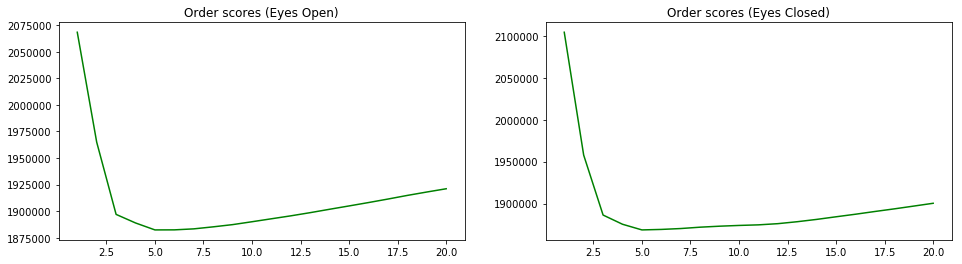

In [5]:
#getting the best order for the open state 
mvar = cp.Mvar

# find best model order using Vieira-Morf algorithm
best_order_open, crit_open = mvar.order_akaike(signal_buffs_open, 20 , 'vm')
# getting the best order for closed state
best_order_closed, crit_closed = mvar.order_akaike(signal_buffs_closed, 20 , 'vm')

fig, (axes_open, axes_closed) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(w=16, h=4)

axes_open.plot(1+np.arange(len(crit_open)), crit_open, 'g')
axes_open.set_title("Order scores (Eyes Open)")
axes_closed.plot(1+np.arange(len(crit_closed)), crit_closed, 'g')
axes_closed.set_title("Order scores (Eyes Closed)")
plt.show()

In [6]:
# function to return MVAR model for given data
def get_mvar_model(data, freq, channel_names, b_order):
    sig_connect = cp.Data(data = data, fs = freq, chan_names = channel_names)
    sig_connect.fit_mvar(b_order, 'yw')
    
    return(sig_connect, *sig_connect.mvar_coefficients)

# get PDC estimators for given data
def get_pdc_matrix(data, freq, channel_names, b_order):
    _, av, vf = get_mvar_model(data, freq, channel_names, b_order)

    pdc = cp.conn.PDC()
    pdc_res = pdc.calculate(av, vf, freq)
    return pdc_res

# get DTF estimators for given data
def get_dtf_matrix(data, freq, channel_names, b_order):
    _, av, vf = get_mvar_model(data, freq, channel_names, b_order)

    dtf = cp.conn.DTF()
    dtf_res = dtf.calculate(av, vf, freq)
    return dtf_res

# get adjacency matrix from estimator data and threshold
def get_edges(threshold, data):
    N = data.shape[0]
    edges = []
    weights = []
    A = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if i != j:
                if data[i,j] > threshold:
                    A[i,j] = 1
                    edges.append((i,j))
                    weights.append(data[i,j])
    return(edges, weights)

# get networkx graph form estimator data with specified edge density
def get_graph(data, target_density):
    nodes = np.arange(data.shape[0])

    data_copy = data.copy()
    np.fill_diagonal(data_copy, 0)
    
    flat_data = sorted(np.ndarray.flatten(data_copy), reverse = True)
    cut_off_index = int(np.ceil(len(flat_data) * target_density/100))
    
    edges, weights = get_edges(flat_data[cut_off_index],data)
    G=nx.DiGraph()
    G.add_edges_from(edges)
    G.add_nodes_from(nodes)

    return (G, edges, weights)

# topological positions for given channels
def get_positions(channel_names, locations):
    return {i: locations[cn] for i, cn in enumerate(channel_names)}

# draws connectivity graph from set estimator data
def draw_graph(adjacency_matrices, node_labels, titles, network_density=20, heatmap = False):
    
    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.set_size_inches(w=12, h=14)
    
    graphs = []

    for i in range(len(adjacency_matrices)):
        axis = axes.flatten()[i]
        G, _, _ = get_graph(adjacency_matrices[i], network_density)
        nodes = np.arange(len(node_labels[i]))
        labels = dict(zip(nodes, node_labels[i]))
        axis.set_title(titles[i])
        nx.draw(G, node_size=500,
                labels=labels,
                with_labels=True,
                pos=get_positions(node_labels[i], locations),
                ax = axis        
               )
        graphs.append(G)
    plt.show()
    return graphs, titles


# plots Power Spectral density estimation
def find_max_psd_frequency(signals, fs, plot_chan, plot_title=''):
    frequencies, psds = sig.welch(signals, fs=fs, nperseg=4*fs)
    
    average_psds = np.average(psds, axis = 0)
    plt.semilogy(frequencies, average_psds)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.title(plot_title, )
    
    plt.show()
    return frequencies[np.argmax(average_psds)]


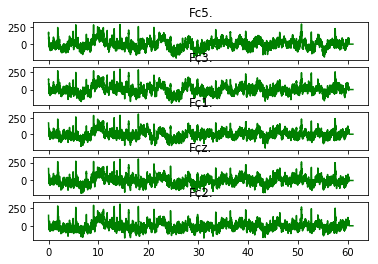

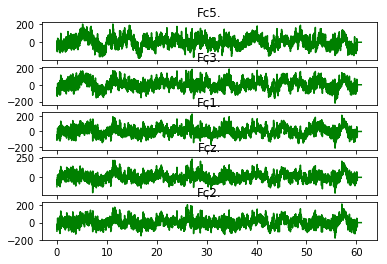

In [7]:
# plot time-series data for visualization

model_open, _, _ = get_mvar_model(signal_buffs_open, sampling_frequency, signal_labels_open, best_order_open)
model_open.select_channels(channels=range(5))
model_open.plot_data()

model_closed, _, _ = get_mvar_model(signal_buffs_closed, sampling_frequency, signal_labels_closed, best_order_closed)
model_closed.select_channels(channels=range(5))
model_closed.plot_data()

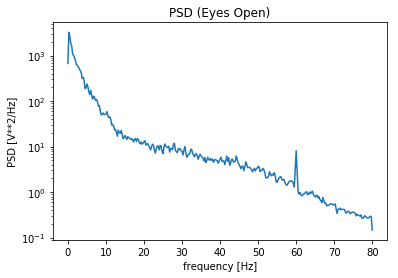

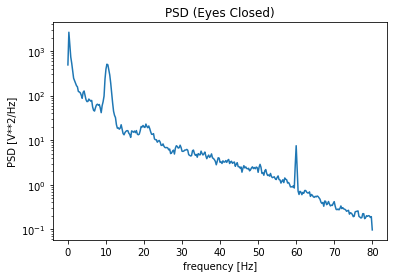

Maximum power spectral density @ frequency:  0.25
Maximum power spectral density @ frequency:  0.25


In [8]:
# plot average Power Spectrum Density on given data

dominant_frequency_open = find_max_psd_frequency(signal_buffs_open, sampling_frequency, 5, plot_title = "PSD (Eyes Open)")
dominant_frequency_closed = find_max_psd_frequency(signal_buffs_closed, sampling_frequency, 5, plot_title = "PSD (Eyes Closed)")

print('Maximum power spectral density @ frequency: ', dominant_frequency_open)
print('Maximum power spectral density @ frequency: ', dominant_frequency_closed)

Observing the power spectral density at two dataset, we can observe the concentration of signal power at frequencies around 0.25 Hz for both dataset, and secondary peak at 10 Hz for second dataset. Hence we proceed our analysis with target frequency of 1 Hz and 10 Hz.

In [9]:
# calculate DTF and PDC estimates for all channel data

pdc_open = get_pdc_matrix(signal_buffs_open, sampling_frequency, signal_labels_open, best_order_open)
dtf_open = get_dtf_matrix(signal_buffs_open, sampling_frequency, signal_labels_open, best_order_open)
pdc_closed = get_pdc_matrix(signal_buffs_closed, sampling_frequency, signal_labels_closed, best_order_closed)
dtf_closed = get_dtf_matrix(signal_buffs_closed, sampling_frequency, signal_labels_closed, best_order_closed)

In [10]:
def draw_all_channels(target_frequency, network_density):
    draw_graph([
                    dtf_open[target_frequency],
                    pdc_open[target_frequency],
                    dtf_closed[target_frequency],
                    pdc_closed[target_frequency]
                ],
                [
                    signal_labels_open,
                    signal_labels_open,
                    signal_labels_closed,
                    signal_labels_closed
                ],
                [
                    'DTF (eyes-open, n/w density {}%, freq {} Hz)'.format(network_density, target_frequency),
                    'PDC (eyes-open, n/w density {}%, freq {} Hz)'.format(network_density, target_frequency),
                    'DTF (eyes-closed, n/w density {}%, freq {} Hz)'.format(network_density, target_frequency),
                    'PDC (eyes-closed, n/w density {}%, freq {} Hz)'.format(network_density, target_frequency)
                ],
                network_density = network_density)

In [11]:
target_frequency = 1

### 1.1 - 1.2 Connectivity Analysis using DTF and PDC measure on 64 channel data at primary frequency band of 1 Hz (delta band)

#### Network Density 20%

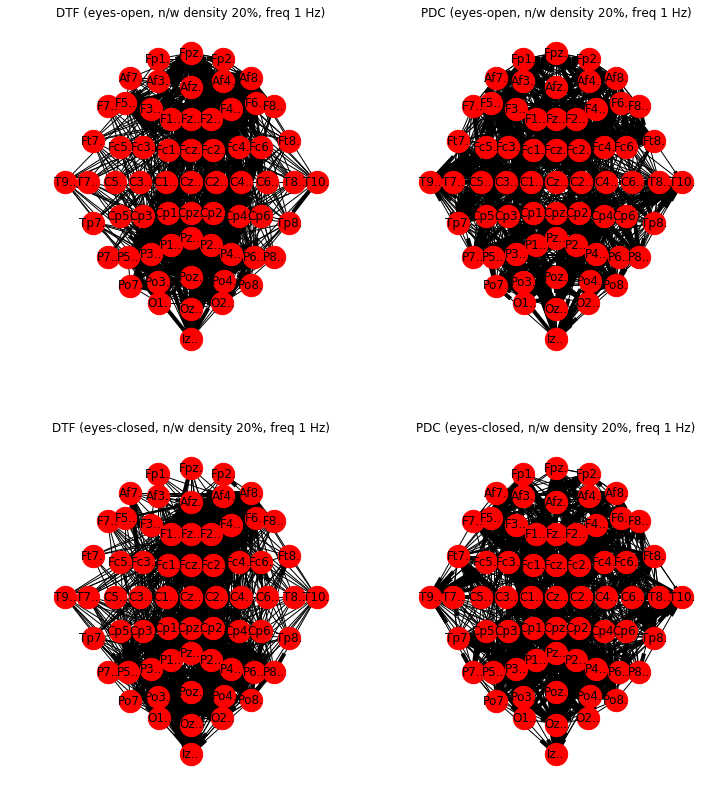

In [12]:
draw_all_channels(target_frequency, 20)

### 1.3 Connectivity Analysis using DTF and PDC measure on 64 channel data multiple network densities in primary frequency band

#### Network Density 1%

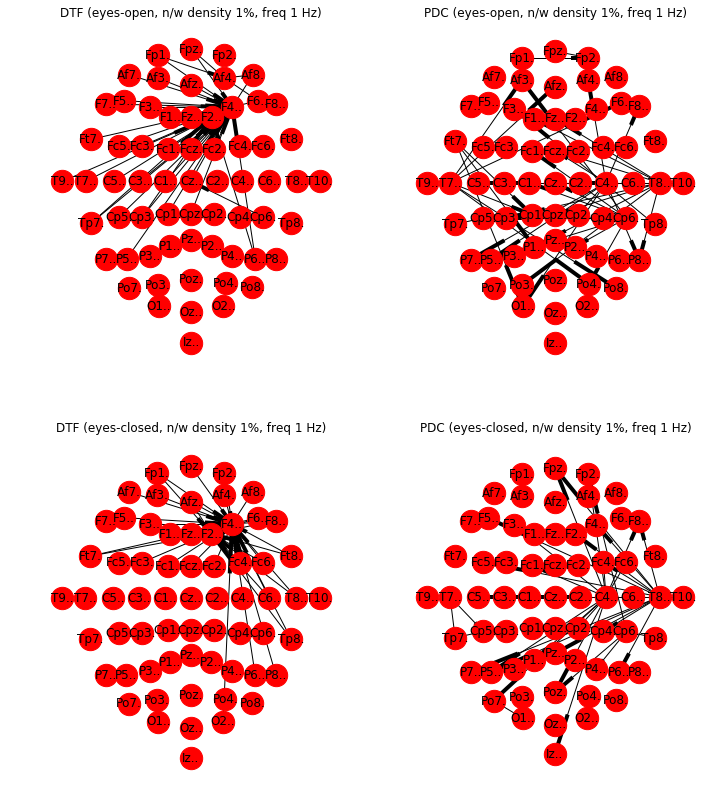

In [13]:
draw_all_channels(target_frequency, 1)

#### Network Density 5%

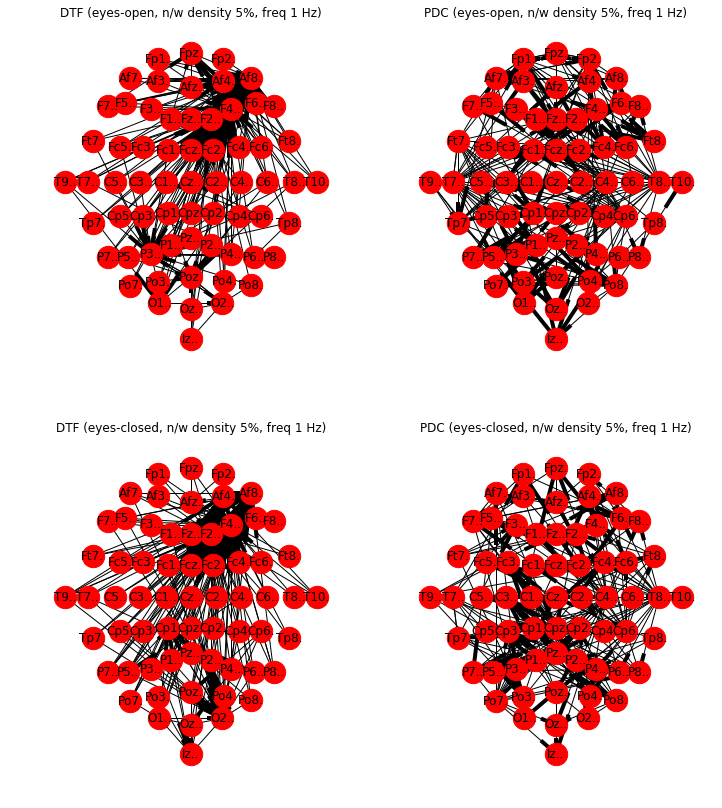

In [14]:
draw_all_channels(target_frequency, 5)

#### Network Density 10%

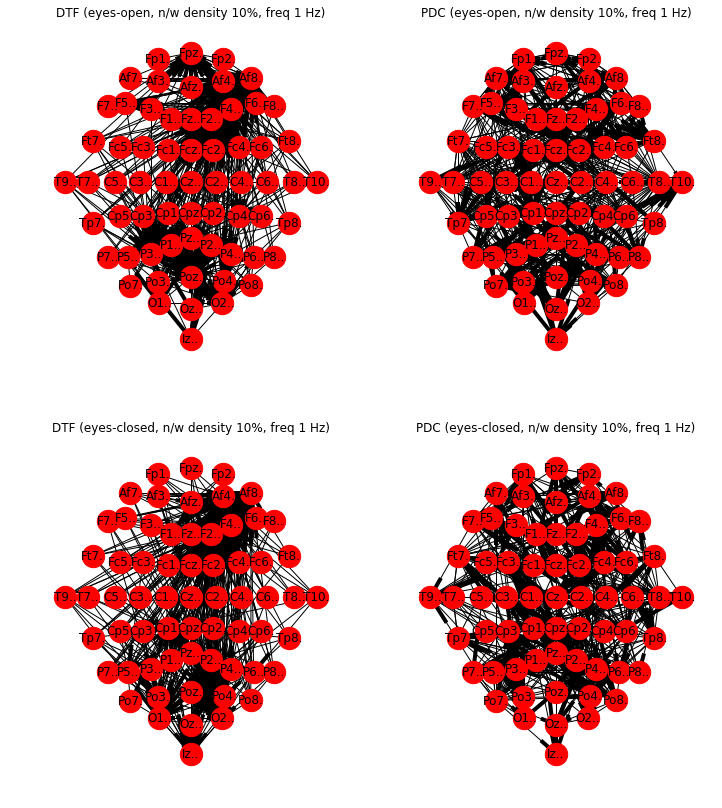

In [15]:
draw_all_channels(target_frequency, 10)

#### Network Density 30%

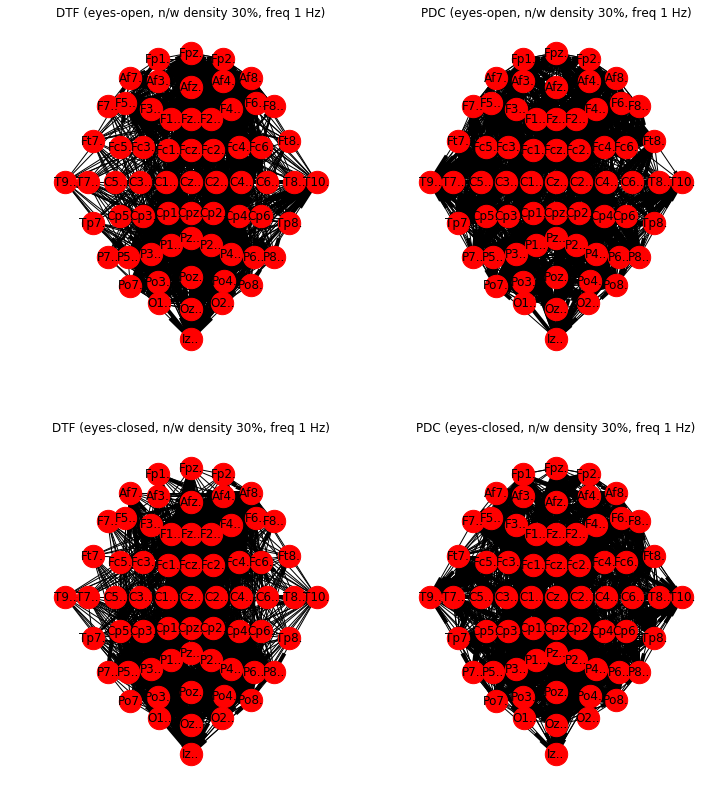

In [16]:
draw_all_channels(target_frequency, 30)

#### Network Density 50%

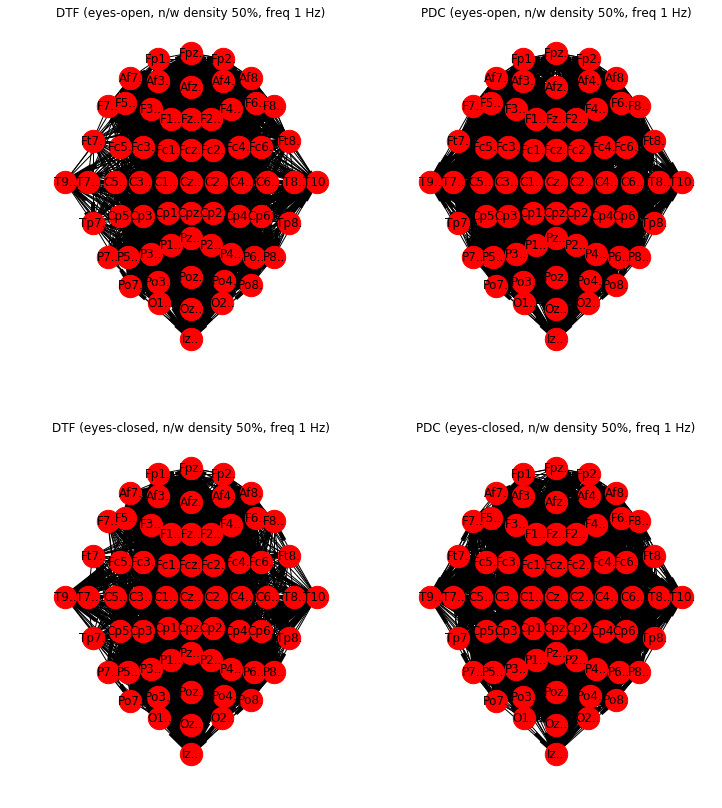

In [17]:
draw_all_channels(target_frequency, 50)

### 1.4 Connectivity Analysis using DTF and PDC measure on 19 channel data with statistical p-value test

In [18]:
# extracting subset datasets for given nodes

subset_channel_names = list(map(lambda x: x.ljust(4, '.'), "Fp1 Fp2 F7 F3 Fz F4 F8 T7 C3 Cz C4 T8 P7 P3 Pz P4 P8 O1 O2".split()))
subset_channel_indexes_open = list(map(lambda x: signal_labels_open.index(x), subset_channel_names))
subset_channel_indexes_closed = list(map(lambda x: signal_labels_closed.index(x), subset_channel_names))

subset_data_open = np.take(signal_buffs_open, subset_channel_indexes_open, axis = 0)
subset_data_closed = np.take(signal_buffs_closed, subset_channel_indexes_closed, axis = 0)


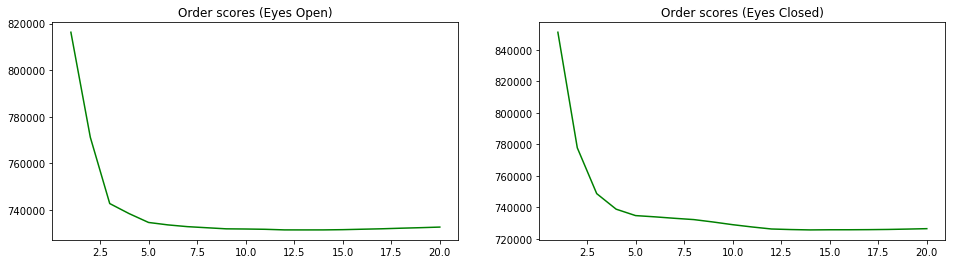

Best Order (Eyes Open): 13
Best Order (Eyes Closed): 13


In [19]:
# MVAR best model order determination

#getting the best order for the open state 
mvar = cp.Mvar

# getting the best order for MVAR
subset_best_order_open, subset_order_scores_open = mvar.order_akaike(subset_data_open, 20 , 'vm')
subset_best_order_closed, subset_order_scores_closed = mvar.order_akaike(subset_data_closed, 20 , 'vm')

# find best model order using Vieira-Morf algorithm
fig, (axes_open, axes_closed) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(w=16, h=4)

axes_open.plot(1+np.arange(len(subset_order_scores_open)), subset_order_scores_open, 'g')
axes_open.set_title("Order scores (Eyes Open)")
axes_closed.plot(1+np.arange(len(subset_order_scores_closed)), subset_order_scores_closed, 'g')
axes_closed.set_title("Order scores (Eyes Closed)")
plt.show()

print("Best Order (Eyes Open):", subset_best_order_open)
print("Best Order (Eyes Closed):", subset_best_order_open)

In [20]:
# MVAR modeling, DFT and PDC estimators

# subset_cpdata_open = cp.Data(data=subset_data_open, fs=sampling_frequency, chan_names=subset_channel_names)
# subset_cpdata_closed = cp.Data(data=subset_data_closed, fs=sampling_frequency, chan_names=subset_channel_names)

dtf = cp.conn.DTF()
pdc = cp.conn.PDC()

In [21]:
# extend connectivipy DTF and PDC module to perform frequency wise significance test

class ImprovedDTF(cp.conn.DTF):
    def levels(self, signi, alpha, k):
        resolutions = signi.shape[1]
        
        if self.two_sided:
            ficance = np.zeros((resolutions, 2, k, k))
        else:
            ficance = np.zeros((resolutions, k, k))

        for freq in range(resolutions):
            for i in range(k):
                for j in range(k):
                    if self.two_sided:
                        ficance[freq][0][i][j] = st.scoreatpercentile(signi[:, freq, i, j], alpha*100)
                        ficance[freq][1][i][j] = st.scoreatpercentile(signi[:, freq, i, j], (1-alpha)*100)
                    else:
                        ficance[freq][i][j] = st.scoreatpercentile(signi[:, freq, i, j], (1-alpha)*100)
        return ficance
    
class ImprovedPDC(cp.conn.PDC):
    def levels(self, signi, alpha, k):
        resolutions = signi.shape[1]
        
        if self.two_sided:
            ficance = np.zeros((resolutions, 2, k, k))
        else:
            ficance = np.zeros((resolutions, k, k))

        for freq in range(resolutions):
            for i in range(k):
                for j in range(k):
                    if self.two_sided:
                        ficance[freq][0][i][j] = st.scoreatpercentile(signi[:, freq, i, j], alpha*100)
                        ficance[freq][1][i][j] = st.scoreatpercentile(signi[:, freq, i, j], (1-alpha)*100)
                    else:
                        ficance[freq][i][j] = st.scoreatpercentile(signi[:, freq, i, j], (1-alpha)*100)
        return ficance

# get DTF and PDC connectivity estimates with statistical p-value test
def get_connectivity_estimates(data, channel_names, order, sampling_frequency = 160, alpha=0.05, Nrep = 100, resolution = 100):
    cp_data = cp.Data(data=data, fs=sampling_frequency, chan_names=channel_names)
    cp_data.fit_mvar(order, 'yw')
    av, vf = cp_data.mvar_coefficients
    
    dtf = ImprovedDTF()
    pdc = ImprovedPDC()
    
    dtf_estimates = dtf.calculate(Acoef=av, Vcoef=vf, fs=sampling_frequency, resolution=resolution)
    dtf_significance = dtf.significance(data, 'yw',
                                            order = order,
                                            resolution = resolution,
                                            Nrep = Nrep,
                                            alpha = alpha,
                                            verbose = False
                                       )

    pdc_estimates = pdc.calculate(Acoef=av, Vcoef=vf, fs=sampling_frequency, resolution=resolution)
    pdc_significance = pdc.significance(data, 'yw',
                                            order = order,
                                            resolution = resolution,
                                            Nrep = Nrep,
                                            alpha = alpha,
                                            verbose = False
                                       )
    for freq in range(resolution):
        dtf_estimates[freq] = dtf_estimates[freq] * (dtf_estimates[freq] > dtf_significance[freq])
        pdc_estimates[freq] = pdc_estimates[freq] * (pdc_estimates[freq] > pdc_significance[freq])
        
    return dtf_estimates, pdc_estimates

In [22]:
dtf_estimates_open, pdc_estimates_open = get_connectivity_estimates(subset_data_open, subset_channel_names, subset_best_order_open)
dtf_estimates_closed, pdc_estimates_closed = get_connectivity_estimates(subset_data_closed, subset_channel_names, subset_best_order_closed)


In [23]:
def draw_subset_channels(target_frequency, network_density):
    draw_graph([
                    dtf_estimates_open[target_frequency],
                    pdc_estimates_open[target_frequency],
                    dtf_estimates_closed[target_frequency],
                    pdc_estimates_closed[target_frequency]
                ],
                [
                    subset_channel_names,
                    subset_channel_names,
                    subset_channel_names,
                    subset_channel_names
                ],
                [
                    'DTF (eyes-open, n/w density {}%, freq {} Hz)'.format(network_density, target_frequency),
                    'PDC (eyes-open, n/w density {}%, freq {} Hz)'.format(network_density, target_frequency),
                    'DTF (eyes-closed, n/w density {}%, freq {} Hz)'.format(network_density, target_frequency),
                    'PDC (eyes-closed, n/w density {}%, freq {} Hz)'.format(network_density, target_frequency)
                ],
                network_density = network_density)

#### Network Density 20%

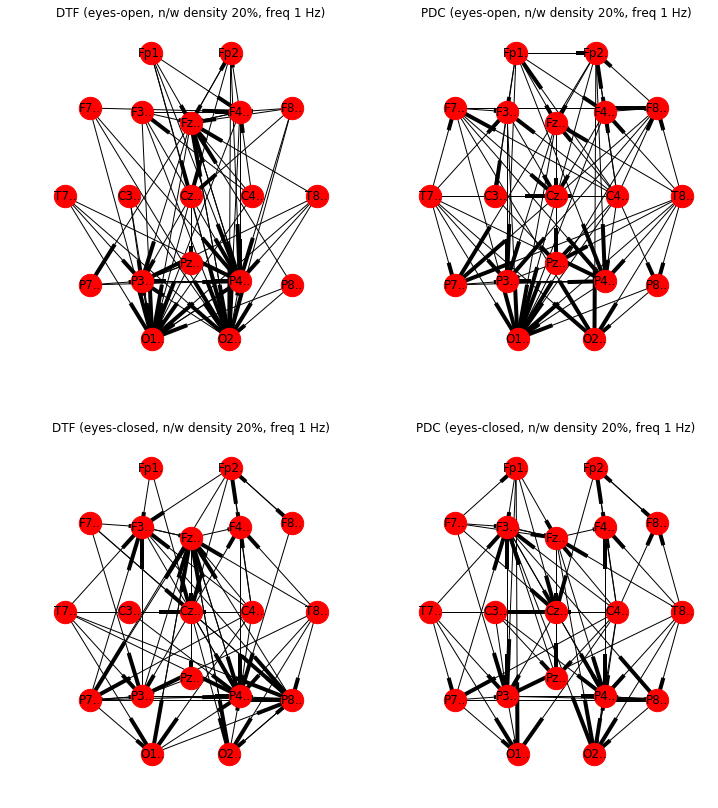

In [24]:
draw_subset_channels(target_frequency, 20)

#### Network Density 1%

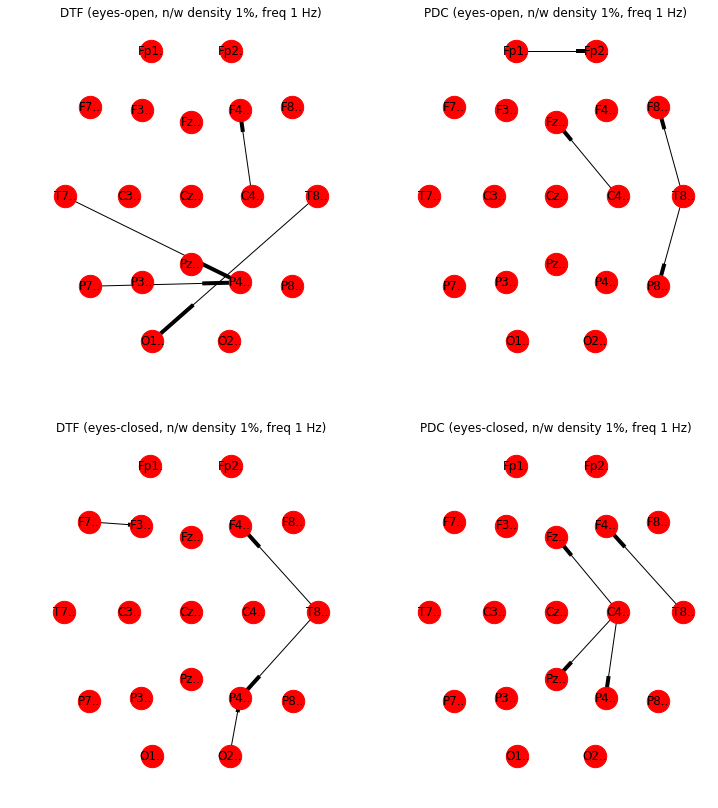

In [25]:
draw_subset_channels(target_frequency, 1)

#### Network Density 5%

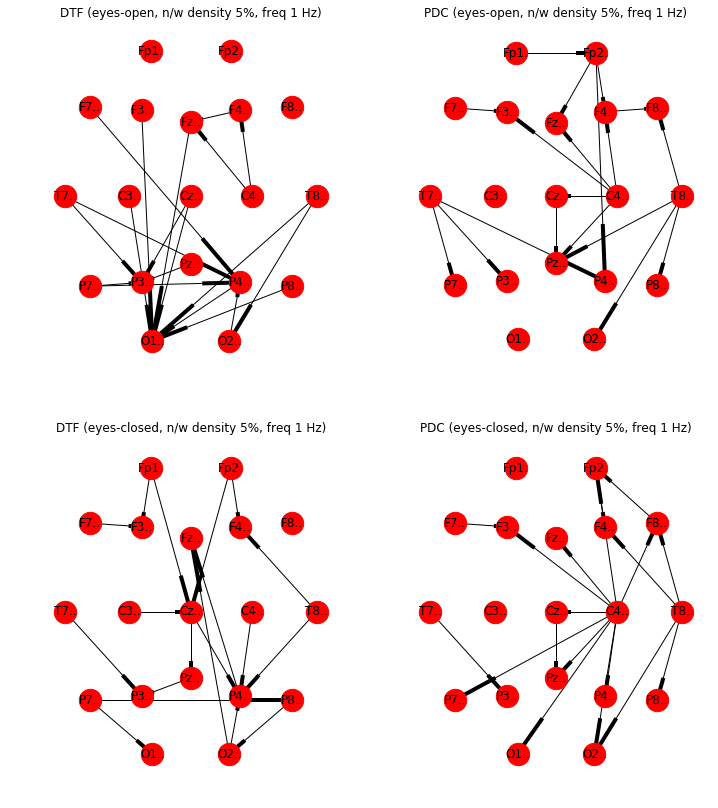

In [26]:
draw_subset_channels(target_frequency, 5)

#### Network Density 10%

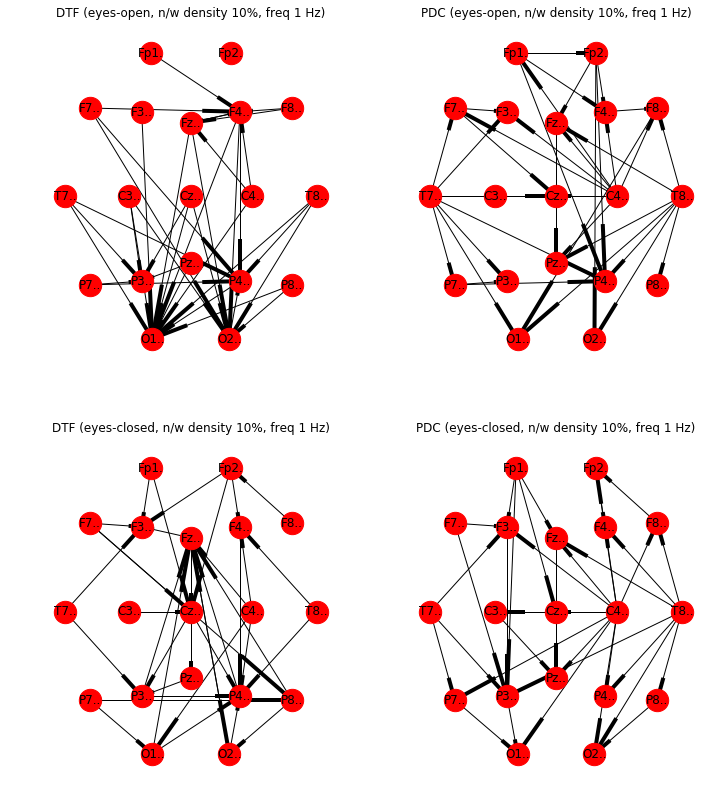

In [27]:
draw_subset_channels(target_frequency, 10)

#### Network Density 30%

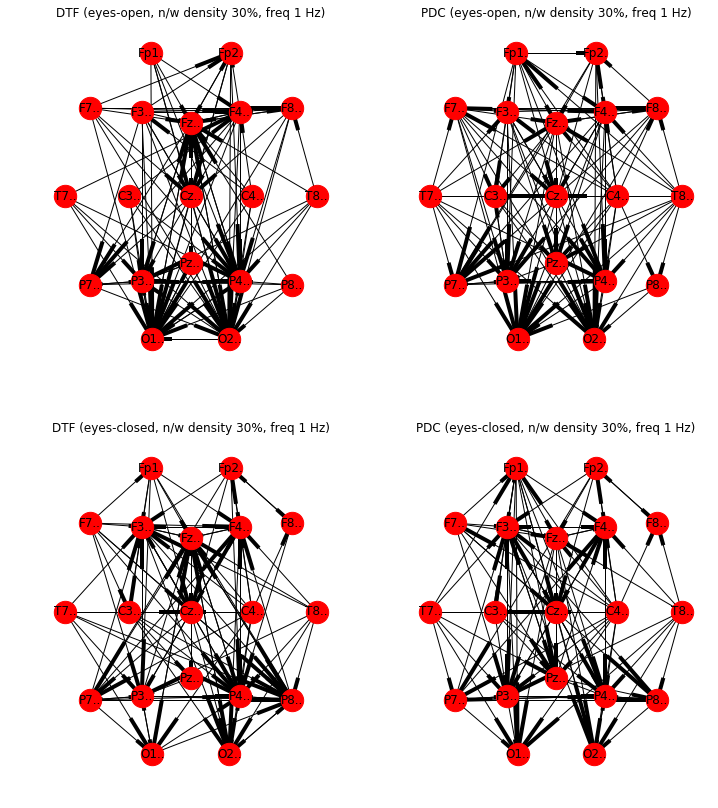

In [28]:
draw_subset_channels(target_frequency, 30)

### 1.5 Connectivity Analysis using DTF and PDC estimators  at secondary frequency 10 Hz (alpha band)

In [29]:
target_frequency = 10

#### Connectivity Graph for all 64 channels

#### Network Density 20%

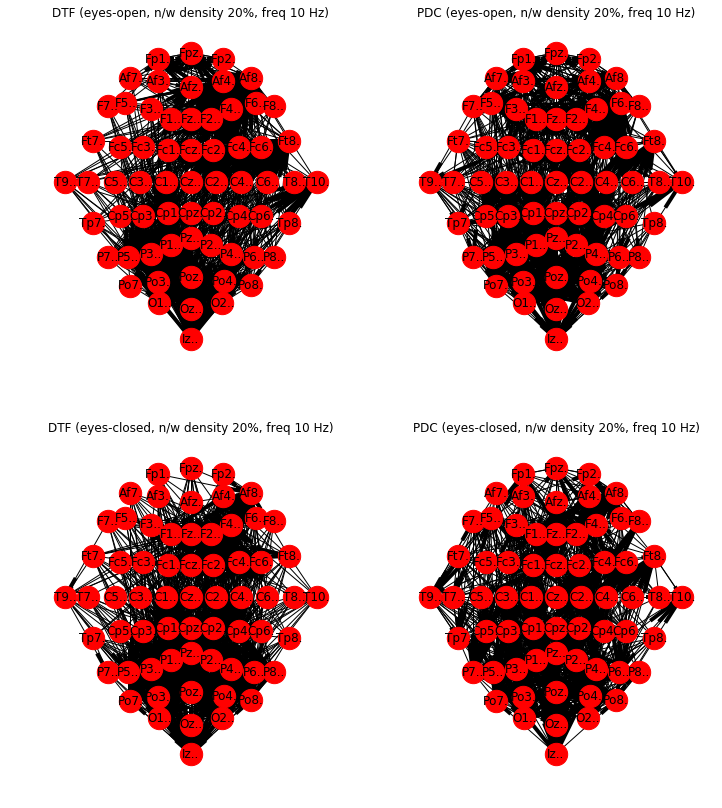

In [30]:
draw_all_channels(target_frequency, 20)

#### Network Density 1%

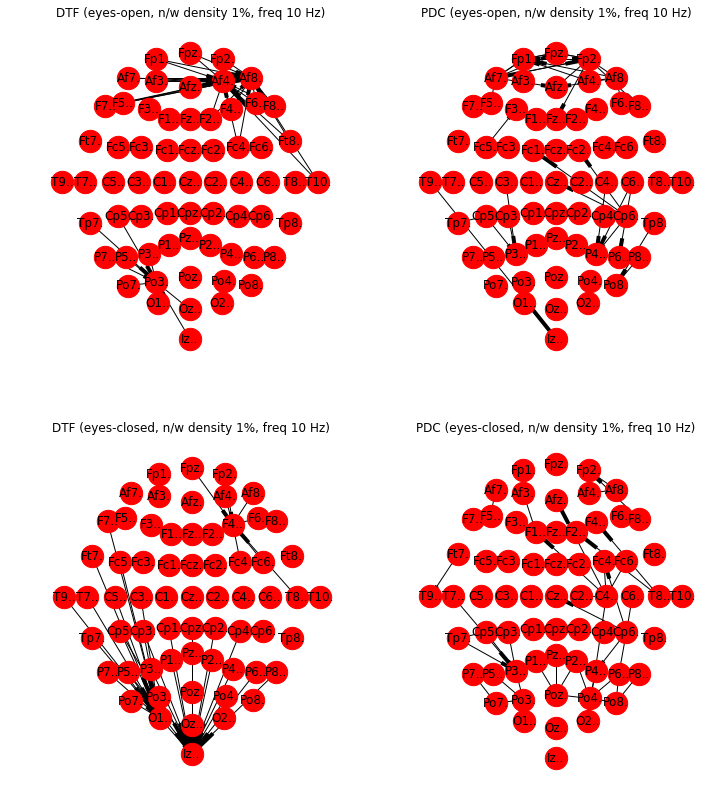

In [31]:
draw_all_channels(target_frequency, 1)

#### Network Density 5%

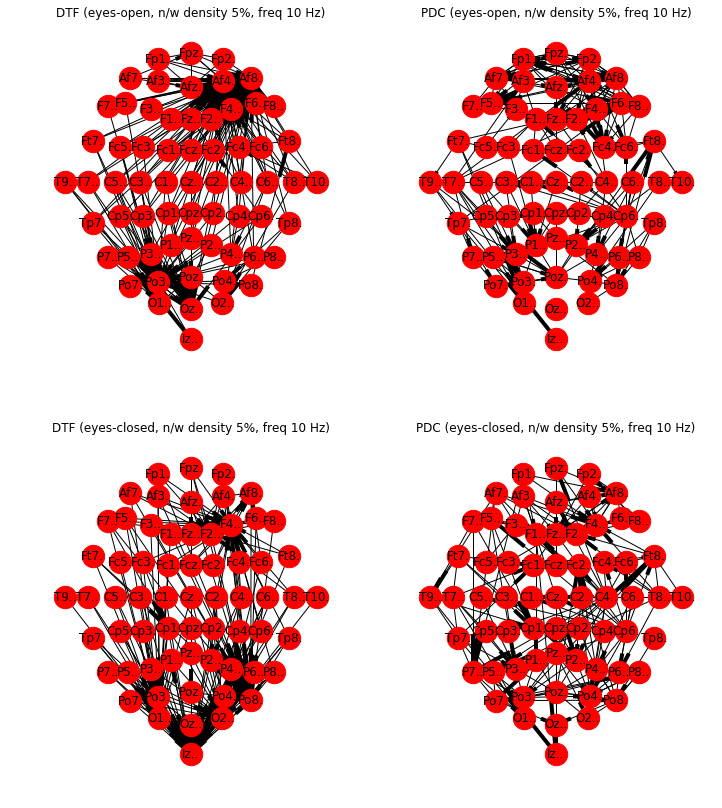

In [32]:
draw_all_channels(target_frequency, 5)

#### Network Density 10%

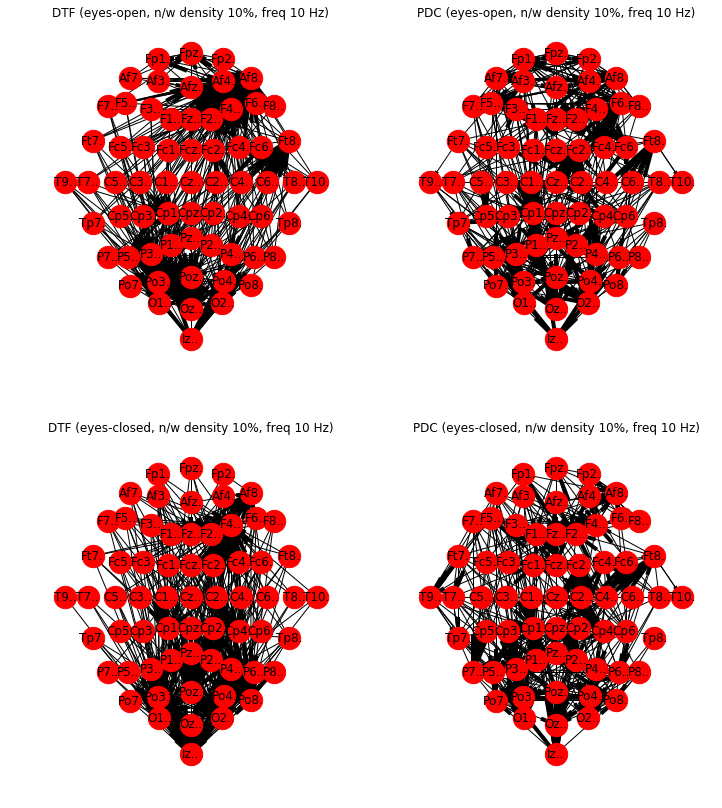

In [33]:
draw_all_channels(target_frequency, 10)

#### Connectivity Graph for 19 channel subset data

#### Network Density 20%

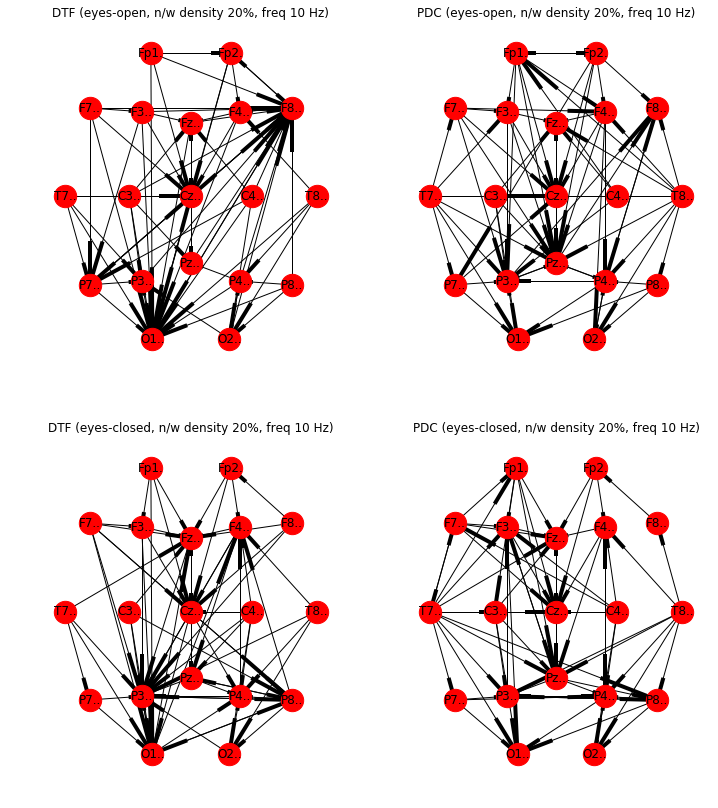

In [34]:
draw_subset_channels(target_frequency, 20)

#### Network Density 1%

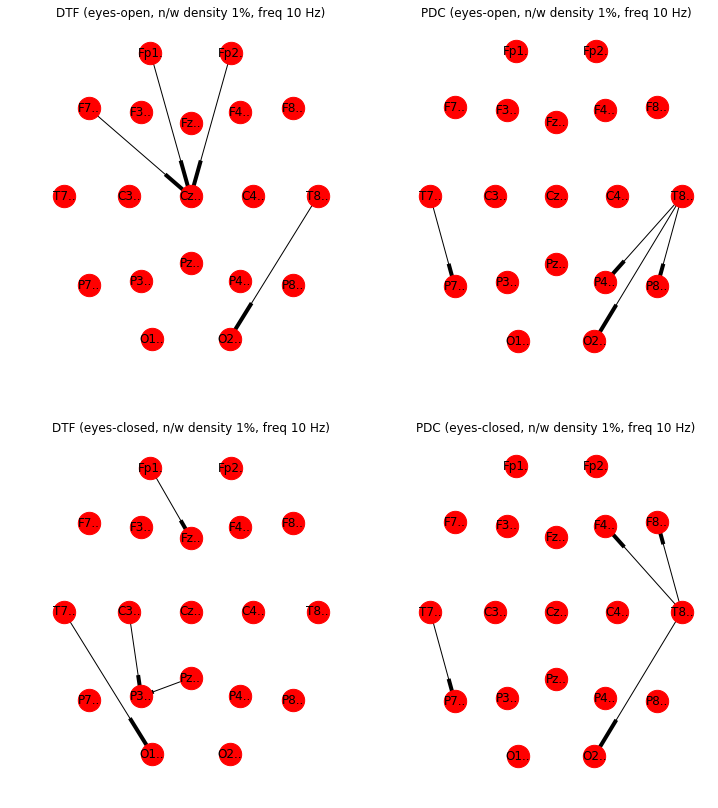

In [35]:
draw_subset_channels(target_frequency, 1)

#### Network Density 5%

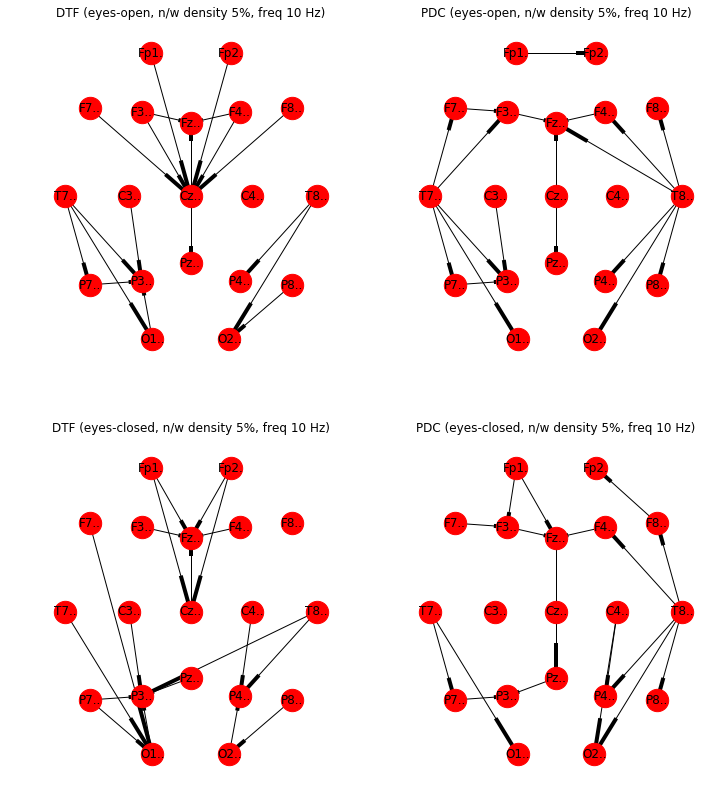

In [36]:
draw_subset_channels(target_frequency, 5)

#### Network Density 10%

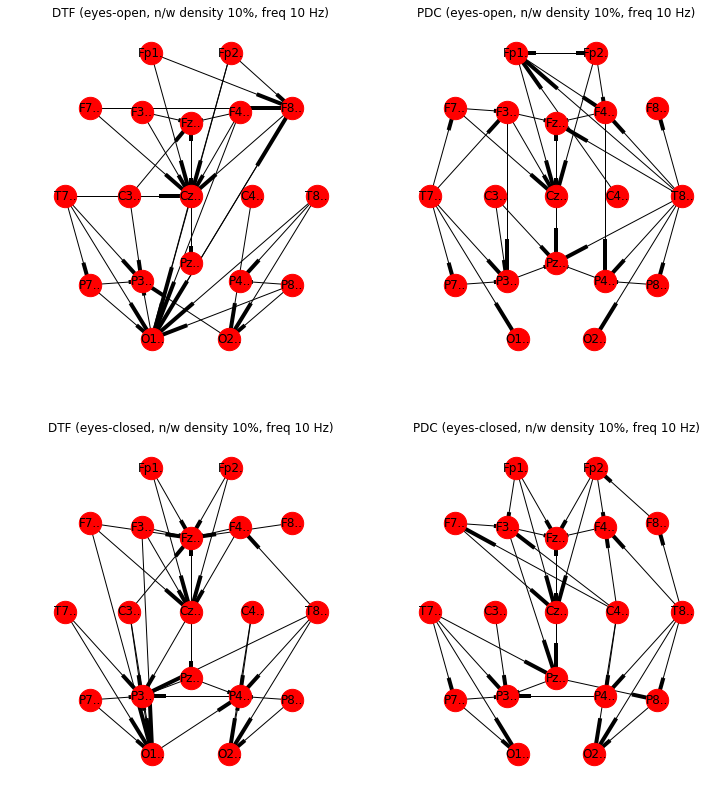

In [37]:
draw_subset_channels(target_frequency, 10)